In [2]:
import sys
sys.path.append('..')
import numpy as np
from utilis.loadweights import *
from utilis.loss import YOLOLoss
from utilis.metrics import YOLOMetrics
from models.darknet19detector import Darknet19Detector
from utilis.dataset import YOLODataset
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Training Yolov2

#### Train for 50 epochs

In [3]:
BATCH_SIZE = 8
LEARNING_RATE = 1e-3
NUM_EPOCHS = 50
ANCHORS = [
    [0.56543644, 0.43573397],
    [0.32582974, 0.32626539],
    [0.15752303, 0.15084553],
    [0.72250432,0.62789971],
]
TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Train and val Dataset
train_dataset = YOLODataset(
    image_dir='../data/resized_train/images',
    label_dir='../data/resized_train/labels',
    anchors=ANCHORS,
    transform=TRANSFORM
)
val_dataset = YOLODataset(
    image_dir='../data/resized_val/images',
    label_dir='../data/resized_val/labels',
    anchors=ANCHORS,
    transform=TRANSFORM
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model, Loss, Optimizer
model = Darknet19Detector(num_classes=4, num_of_anchors=4)
model = load_yolov2_weights(model, "../weights/yolov2.weights")
print("Weights loaded successfully!")
criterion = YOLOLoss(num_classes=4, anchors=ANCHORS)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0005)
model.to(device)

best_map = -float('inf')

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    print(f'Starting epoch {epoch+1}/{NUM_EPOCHS}')
    for images, targets in train_loader:
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_metrics = YOLOMetrics(num_classes=4, anchors=ANCHORS)
    
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            # Update metrics
            val_metrics.update_metrics(outputs.cpu(), targets.cpu())
    
    # Calculate metrics
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    metrics = val_metrics.compute_metrics()
    current_map = metrics['map']

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"mAP@0.5: {metrics['map_50']:.4f} | mAP@0.5:0.95: {metrics['map']:.4f}")
    print("------------------------")
    
    # Save best model
    if current_map > best_map:
        best_map = current_map
        torch.save(model.state_dict(), 'best_model_fixedloss_fixedlabelproblem.pth')

    val_metrics.reset()

Weights loaded successfully!
Starting epoch 1/50
Epoch 1/50
Train Loss: 47.9364 | Val Loss: 14.0186
mAP@0.5: 0.0000 | mAP@0.5:0.95: 0.0000
------------------------
Starting epoch 2/50
Epoch 2/50
Train Loss: 14.3081 | Val Loss: 12.9890
mAP@0.5: 0.0000 | mAP@0.5:0.95: 0.0000
------------------------
Starting epoch 3/50
Epoch 3/50
Train Loss: 13.6197 | Val Loss: 12.3610
mAP@0.5: 0.0000 | mAP@0.5:0.95: 0.0000
------------------------
Starting epoch 4/50
Epoch 4/50
Train Loss: 12.6037 | Val Loss: 11.5081
mAP@0.5: 0.0000 | mAP@0.5:0.95: 0.0000
------------------------
Starting epoch 5/50
Epoch 5/50
Train Loss: 11.4087 | Val Loss: 11.1815
mAP@0.5: 0.0000 | mAP@0.5:0.95: 0.0000
------------------------
Starting epoch 6/50
Epoch 6/50
Train Loss: 11.6320 | Val Loss: 11.5591
mAP@0.5: 0.0050 | mAP@0.5:0.95: 0.0005
------------------------
Starting epoch 7/50
Epoch 7/50
Train Loss: 11.1071 | Val Loss: 10.8944
mAP@0.5: 0.0050 | mAP@0.5:0.95: 0.0010
------------------------
Starting epoch 8/50
Epoch 

#### Visualize the training process

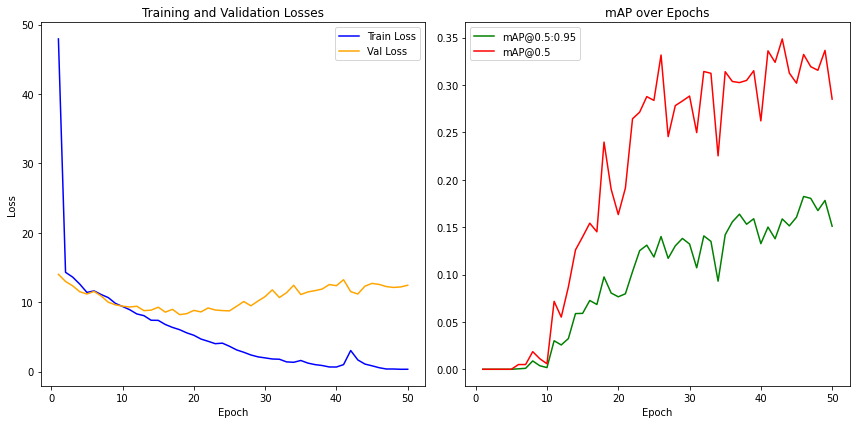

In [7]:
import matplotlib.pyplot as plt

# Train and Validation history
epochs = list(range(1, 51))
train_losses = [47.9364, 14.3081, 13.6197, 12.6037, 11.4087, 11.6320, 11.1071, 10.6627, 9.8298, 9.3840, 8.9221, 8.3107, 8.0633, 7.4038, 7.3863, 6.7884, 6.3720, 6.0442, 5.5864, 5.2384, 4.6936, 4.3717, 4.0263, 4.1024, 3.6509, 3.1280, 2.7893, 2.4009, 2.1273, 1.9791, 1.8213, 1.7853, 1.4052, 1.3452, 1.6058, 1.2283, 1.0095, 0.8815, 0.6704, 0.6652, 1.0114, 3.0437, 1.6850, 1.0883, 0.8370, 0.5630, 0.3790, 0.3785, 0.3384, 0.3415]
val_losses = [14.0186, 12.9890, 12.3610, 11.5081, 11.1815, 11.5591, 10.8944, 9.9978, 9.6216, 9.4322, 9.3133, 9.4196, 8.7882, 8.8564, 9.2819, 8.5693, 8.9766, 8.2124, 8.3545, 8.8219, 8.6085, 9.1683, 8.8801, 8.7967, 8.7554, 9.4183, 10.0983, 9.4863, 10.1703, 10.8141, 11.7789, 10.6775, 11.3711, 12.4428, 11.1075, 11.4833, 11.6704, 11.9010, 12.5480, 12.3826, 13.2405, 11.5278, 11.1801, 12.3162, 12.7139, 12.5609, 12.2557, 12.1303, 12.2000, 12.4430]
map05_values = [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0050, 0.0050, 0.0186, 0.0111, 0.0058, 0.0717, 0.0551, 0.0869, 0.1260, 0.1398, 0.1542, 0.1451, 0.2398, 0.1901, 0.1633, 0.1913, 0.2644, 0.2714, 0.2878, 0.2838, 0.3317, 0.2456, 0.2783, 0.2832, 0.2884, 0.2498, 0.3143, 0.3124, 0.2253, 0.3141, 0.3038, 0.3026, 0.3049, 0.3151, 0.2622, 0.3361, 0.3240, 0.3487, 0.3126, 0.3020, 0.3323, 0.3194, 0.3156, 0.3366, 0.2852]
map05_095_values = [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0005, 0.0010, 0.0088, 0.0037, 0.0018, 0.0301, 0.0257, 0.0324, 0.0588, 0.0590, 0.0726, 0.0684, 0.0975, 0.0805, 0.0765, 0.0797, 0.1031, 0.1252, 0.1310, 0.1185, 0.1401, 0.1171, 0.1303, 0.1381, 0.1322, 0.1071, 0.1408, 0.1350, 0.0930, 0.1420, 0.1556, 0.1637, 0.1531, 0.1589, 0.1326, 0.1501, 0.1378, 0.1587, 0.1514, 0.1605, 0.1824, 0.1804, 0.1675, 0.1782, 0.1510]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color='blue')
plt.plot(epochs, val_losses, label="Val Loss", color='orange')
plt.title("Training and Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot mAP values
plt.subplot(1, 2, 2)
plt.plot(epochs, map05_095_values, label="mAP@0.5:0.95", color='green')
plt.plot(epochs, map05_values, label="mAP@0.5", color='red')
plt.title("mAP over Epochs")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()


#### Training for another 20 epochs

In [5]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0005)
for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    print(f'Starting epoch {epoch+1}/{NUM_EPOCHS}')
    for images, targets in train_loader:
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_metrics = YOLOMetrics(num_classes=4, anchors=ANCHORS)
    
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            # Update metrics
            val_metrics.update_metrics(outputs.cpu(), targets.cpu())
    
    # Calculate metrics
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    metrics = val_metrics.compute_metrics()
    current_map = metrics['map']

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"mAP@0.5: {metrics['map_50']:.4f} | mAP@0.5:0.95: {metrics['map']:.4f}")
    print("------------------------")
    
    # Save best model
    if current_map > best_map:
        best_map = current_map
        torch.save(model.state_dict(), 'best_model_fixedloss_fixedlabelproblem_70.pth')

    val_metrics.reset()

Starting epoch 1/20
Epoch 1/20
Train Loss: 0.2277 | Val Loss: 12.4436
mAP@0.5: 0.3125 | mAP@0.5:0.95: 0.1886
------------------------
Starting epoch 2/20
Epoch 2/20
Train Loss: 0.1177 | Val Loss: 12.9163
mAP@0.5: 0.3046 | mAP@0.5:0.95: 0.1770
------------------------
Starting epoch 3/20
Epoch 3/20
Train Loss: 0.0963 | Val Loss: 12.6426
mAP@0.5: 0.3298 | mAP@0.5:0.95: 0.2003
------------------------
Starting epoch 4/20
Epoch 4/20
Train Loss: 0.0858 | Val Loss: 13.1841
mAP@0.5: 0.3133 | mAP@0.5:0.95: 0.1883
------------------------
Starting epoch 5/20
Epoch 5/20
Train Loss: 0.0842 | Val Loss: 13.0639
mAP@0.5: 0.3100 | mAP@0.5:0.95: 0.1900
------------------------
Starting epoch 6/20
Epoch 6/20
Train Loss: 0.0867 | Val Loss: 13.3880
mAP@0.5: 0.3182 | mAP@0.5:0.95: 0.1974
------------------------
Starting epoch 7/20
Epoch 7/20
Train Loss: 0.0913 | Val Loss: 13.3646
mAP@0.5: 0.3283 | mAP@0.5:0.95: 0.1939
------------------------
Starting epoch 8/20
Epoch 8/20
Train Loss: 0.0916 | Val Loss: 

#### Visualize the whole training history

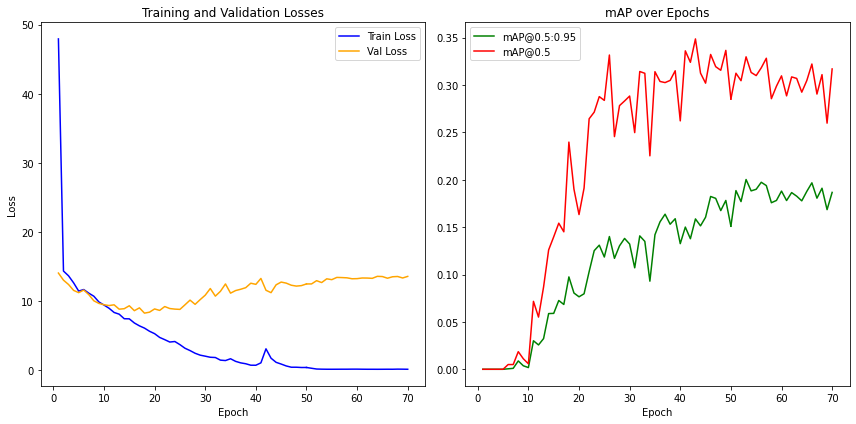

In [15]:
epochs_2 = list(range(50, 71))
train_losses_2 = [0.3415,0.2277, 0.1177, 0.0963, 0.0858, 0.0842, 0.0867, 0.0913, 0.0916, 0.0995, 0.1005, 0.0899, 0.0830, 0.0830, 0.0801, 0.0830, 0.0879, 0.0849, 0.1017, 0.0951, 0.0837]
val_losses_2 = [12.4430,12.4436, 12.9163, 12.6426, 13.1841, 13.0639, 13.3880, 13.3646, 13.3273, 13.1932, 13.2109, 13.3030, 13.2941, 13.2542, 13.5448, 13.5135, 13.2701, 13.4814, 13.5221, 13.3065, 13.5368]
map05_values_2 = [0.2852,0.3125, 0.3046, 0.3298, 0.3133, 0.3100, 0.3182, 0.3283, 0.2856, 0.2988, 0.3097, 0.2886, 0.3086, 0.3070, 0.2925, 0.3048, 0.3222, 0.2905, 0.3110, 0.2598, 0.3170]
map05_095_values_2 = [0.1510,0.1886, 0.1770, 0.2003, 0.1883, 0.1900, 0.1974, 0.1939, 0.1758, 0.1782, 0.1881, 0.1781, 0.1865, 0.1827, 0.1778, 0.1878, 0.1968, 0.1806, 0.1911, 0.1685, 0.1867]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color='blue')
plt.plot(epochs, val_losses, label="Val Loss", color='orange')
plt.plot(epochs_2, train_losses_2, color='blue')
plt.plot(epochs_2, val_losses_2, color='orange')
plt.title("Training and Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot mAP values
plt.subplot(1, 2, 2)
plt.plot(epochs, map05_095_values, label="mAP@0.5:0.95", color='green')
plt.plot(epochs_2, map05_095_values_2, color='green')
plt.plot(epochs, map05_values, label="mAP@0.5", color='red')
plt.plot(epochs_2, map05_values_2, color='red')
plt.title("mAP over Epochs")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()